# Yellow Taxi Data performance - Part 6

In this notebook, we compare the efficiency and performance of querying parquet on Vast S3 versus Vast DB.

You should have already performed the steps in [Parts 0 .. 5](https://github.com/snowch/vast-docker-compose-examples/tree/main/jupyter-pyspark/examples/taxi_data) before running this notebook.
    
<div class="alert alert-block alert-info">
💡 <b>NOTE</b>
<br/>
<ul>
<li>The <b>hive3x</b> and <b>trino</b> projects need to be running for this notebook.</li>
<li>You can run projects with `cd the-project && docker compose up -d --wait`.</li>
</ul>
</div>


In [ ]:
import os
DOCKER_HOST_OR_IP = os.getenv('DOCKER_HOST_OR_IP')
VASTDB_NYT_BUCKET = os.getenv('VASTDB_NYT_BUCKET')
VASTDB_NYT_SCHEMA = os.getenv('VASTDB_NYT_SCHEMA')
VASTDB_NYT_TABLE = os.getenv('VASTDB_NYT_TABLE')

print(VASTDB_NYT_BUCKET, VASTDB_NYT_SCHEMA, VASTDB_NYT_TABLE)

S3A_BUCKET = os.getenv('S3A_BUCKET')
S3_HIVE_TAXI_URI = os.getenv("S3A_HIVE_TAXI_URI")

print(S3_HIVE_TAXI_URI)

In [ ]:
import time
from trino.dbapi import connect

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

conn = connect(
    host=DOCKER_HOST_OR_IP,
    port=8443,
    user="admin",
    catalog="system",
    schema="",
    verify=False,
    http_scheme="https"
)

## VastDB Filter Select

In [ ]:
%%time

import pandas as pd

cur = conn.cursor()
cur.execute(f"""
select 
    *
from
    vast."{VASTDB_NYT_BUCKET}|{VASTDB_NYT_SCHEMA}".{VASTDB_NYT_TABLE}
where
    trip_distance > 129.5 and trip_distance < 130.0
""")

# Fetch the results and create a DataFrame
df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

vastdb_stats = cur.stats

# Close the cursor and connection
cur.close()
conn.close()

df

In [ ]:
print(f"""
VastDB stats
------------
Processed Rows: {vastdb_stats['processedRows']:,}
Processed MBytes: {vastdb_stats['processedBytes'] / 1024 / 1024:.4f}
CPU Time Millis: {vastdb_stats['cpuTimeMillis']}
Query Time Millis: {vastdb_stats['elapsedTimeMillis']}
""")

<div class="alert alert-block alert-info">
💡 <b>Why use trip_distance > 129.5 and trip_distance < 130.0?</b>
<br/>
I wanted to have a filter that would result in only about 20 rows so that they could all be displayed in the notebook.
I started by performing a statistical analysis of trip_distance values and `129.5 < trip_distance < 130.0` met the criteria.
</div>

## Hive Filter Select

In [ ]:
%%time

import pandas as pd

cur = conn.cursor()
cur.execute(f"""
SELECT 
    *
FROM 
    hive.nyt.yellow_tripdata
where
    trip_distance > 129.5 and trip_distance < 130.0
""")

# Fetch the results and create a DataFrame
df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

hive_stats = cur.stats

# Close the cursor and connection
cur.close()
conn.close()

df

In [ ]:
print(f"""
Hive Stats
----------
Processed Rows: {hive_stats['processedRows']:,}
Processed MBytes: {hive_stats['processedBytes'] / 1024 / 1024:.2f}
CPU Time Millis: {hive_stats['cpuTimeMillis']}
Query Time Millis: {hive_stats['elapsedTimeMillis']}
""")

## Comparison

Create a function to print the comparision statistics

In [ ]:
import pandas as pd
import numpy as np

def print_stats():
    # Create a DataFrame for the stats
    data = {
        'Metric': [
            'Processed Rows', 
            'Processed Bytes', 
            'CPU Time (ms)', 
            'Query Time (ms)'
        ],
        'Hive': [
            int(hive_stats['processedRows']), 
            float(hive_stats['processedBytes']), 
            int(hive_stats['cpuTimeMillis']), 
            int(hive_stats['elapsedTimeMillis'])
        ],
        'VastDB': [
            int(vastdb_stats['processedRows']), 
            float(vastdb_stats['processedBytes']), 
            int(vastdb_stats['cpuTimeMillis']), 
            int(vastdb_stats['elapsedTimeMillis'])
        ],
        'Label': [
            'more efficient',
            'more efficient',
            'faster',
            'faster'
        ]
    }

    df = pd.DataFrame(data)

    # Calculate the VastDB Performance
    df['VastDB Performance'] = df['Hive'] / df['VastDB']
    
    # Handle infinity and NaN values explicitly
    df['VastDB Performance'] = df['VastDB Performance'].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Round the 'VastDB Performance' to remove decimals and add 'x'
    df['VastDB Performance'] = df['VastDB Performance'].apply(lambda x: f"{int(x):,}x" if x != 0 else "0x")
    
    # Left-align the 'Performance & Label' column and space-pad the numerical values
    df['VastDB Performance'] = df['VastDB Performance'].apply(lambda x: x.ljust(25))

    df['Hive'] = df['Hive'].apply(lambda x: f"{int(x):,}")
    df['VastDB'] = df['VastDB'].apply(lambda x: f"{int(x):,}")
    
    # Reorder the columns to include the combined column
    df = df[['Metric', 'Hive', 'VastDB', 'VastDB Performance']]

    return df

print_stats()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Create a DataFrame using the dictionary data
df = pd.DataFrame({
    'System': ['Parquet on S3', 'VastDB'],
    'Processed Rows': [hive_stats['processedRows'], vastdb_stats['processedRows']],
    'Processed Bytes': [hive_stats['processedBytes'], vastdb_stats['processedBytes']],
    'CPU Time (ms)': [hive_stats['cpuTimeMillis'], vastdb_stats['cpuTimeMillis']],
    'Query Time (ms)': [hive_stats['elapsedTimeMillis'], vastdb_stats['elapsedTimeMillis']],
})

# Formatter function for millions
def millions_formatter(x, pos):
    return f'{int(x):,}'

def add_values_above_bars(ax, values, gap=0.05):
    for i, value in enumerate(values):
        ax.text(i, value + gap * max(values), f'{value:,.0f}', ha='center', va='bottom', fontsize=9)


# Create a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Processed Rows
axes[0, 0].bar([0, 1], df['Processed Rows'], tick_label=df['System'])
axes[0, 0].set_title('Processed Rows')
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
axes[0, 0].set_ylim(0, max(df['Processed Rows']) * 1.2)  # Extend y-axis by 20%
add_values_above_bars(axes[0, 0], df['Processed Rows'])

# Processed MB
axes[0, 1].bar([0, 1], df['Processed Bytes'], tick_label=df['System'])
axes[0, 1].set_title('Processed Bytes')
axes[0, 1].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
axes[0, 1].set_ylim(0, max(df['Processed Bytes']) * 1.2)  # Extend y-axis by 20%
add_values_above_bars(axes[0, 1], df['Processed Bytes'])

# CPU Time
axes[1, 0].bar([0, 1], df['CPU Time (ms)'], tick_label=df['System'])
axes[1, 0].set_title('CPU Time (ms)')
axes[1, 0].set_ylim(0, max(df['CPU Time (ms)']) * 1.2)  # Extend y-axis by 20%
add_values_above_bars(axes[1, 0], df['CPU Time (ms)'])

# Query Time
axes[1, 1].bar([0, 1], df['Query Time (ms)'], tick_label=df['System'])
axes[1, 1].set_title('Query Time (ms)')
axes[1, 1].set_ylim(0, max(df['Query Time (ms)']) * 1.2)  # Extend y-axis by 20%
add_values_above_bars(axes[1, 1], df['Query Time (ms)'])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Conclusion

In [ ]:
print_stats()

##### You can observe that

- much less data being transferred back to Trino:
  - Hive: 18M rows vs VastDB: 19 rows
  - Hive: 200MB vs VastDB 0.004MB
- much lower processing required in Trino:
  - Hive has about 5x to 11x more processing required in Trino vs VastDB


These figures are consistent with customer benchmarks of Parquet on S3 (Vast and Cloud) vs Vast DB.

We can see how query predicate pushdown has much less processing required by Vast DB due to its **efficient storage** in the element store vs parquet files that are typically 100's of MBs.

<div class="alert alert-block alert-info">
🔑 <b>KEY TAKEAWAY</b> 
<br/>
VastDB's high performance and efficiency are driven by its advanced storage layout, while Parquet on S3 is comparatively very inefficient.
</div>

<div class="alert alert-block alert-info">
💡 <b>NOTE</b> 
<br/>
Note that optimisations may be possible with Hive by using partitioning, etc., and also with Vast DB using projections.  However, it is expected that VastDB will always out perform parquet based approaches because it requires less data reads to retrieve the data requested.
</div>



<hr/>

## Appendix: Exploring Queries using the Trino UI

You can also view the stats in the Trino UI:

- Retrieve the Trino UI url with `./scripts/endpoints_all.sh`
- Login with username: **admin**
- Click on the **Query ID** link under **Query Details**
- Navigate to Live Plan


<img src="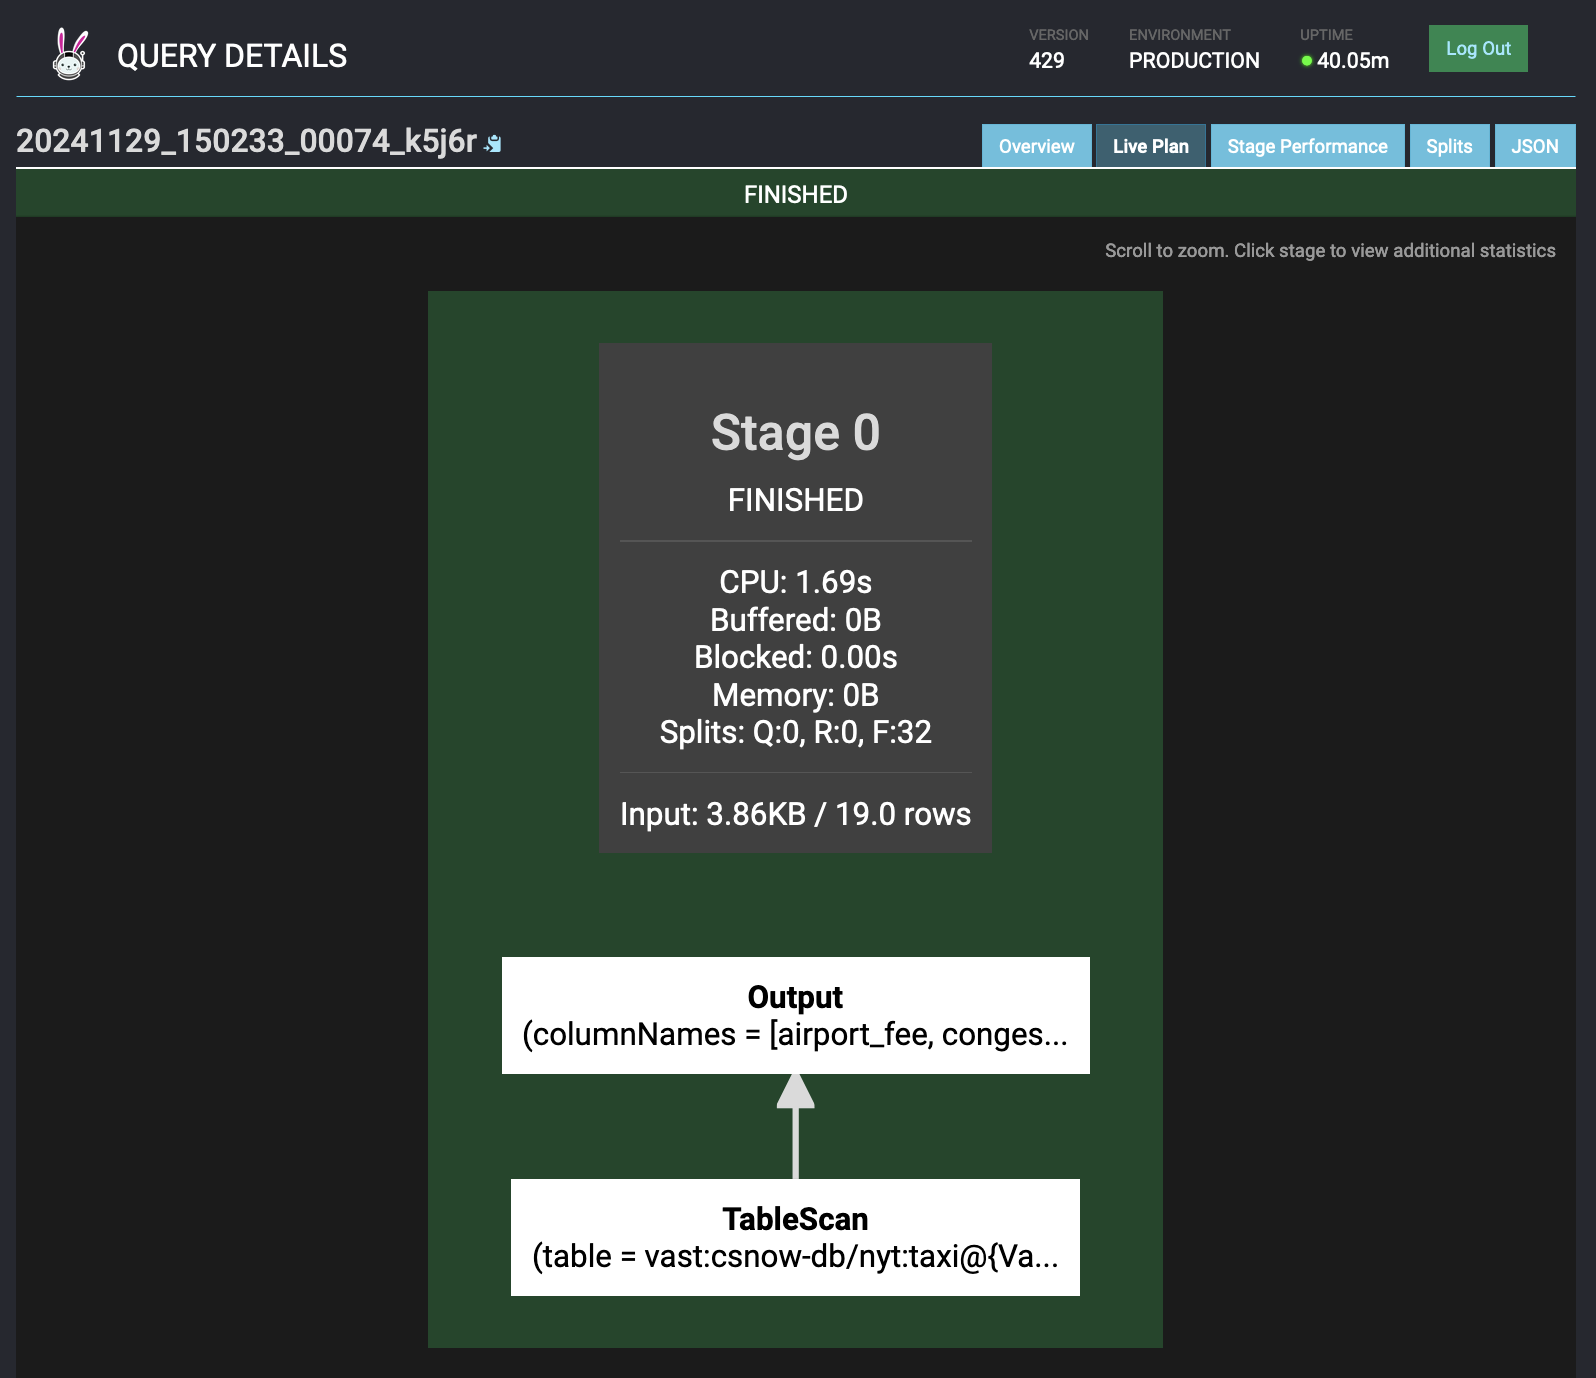
" />

<img src="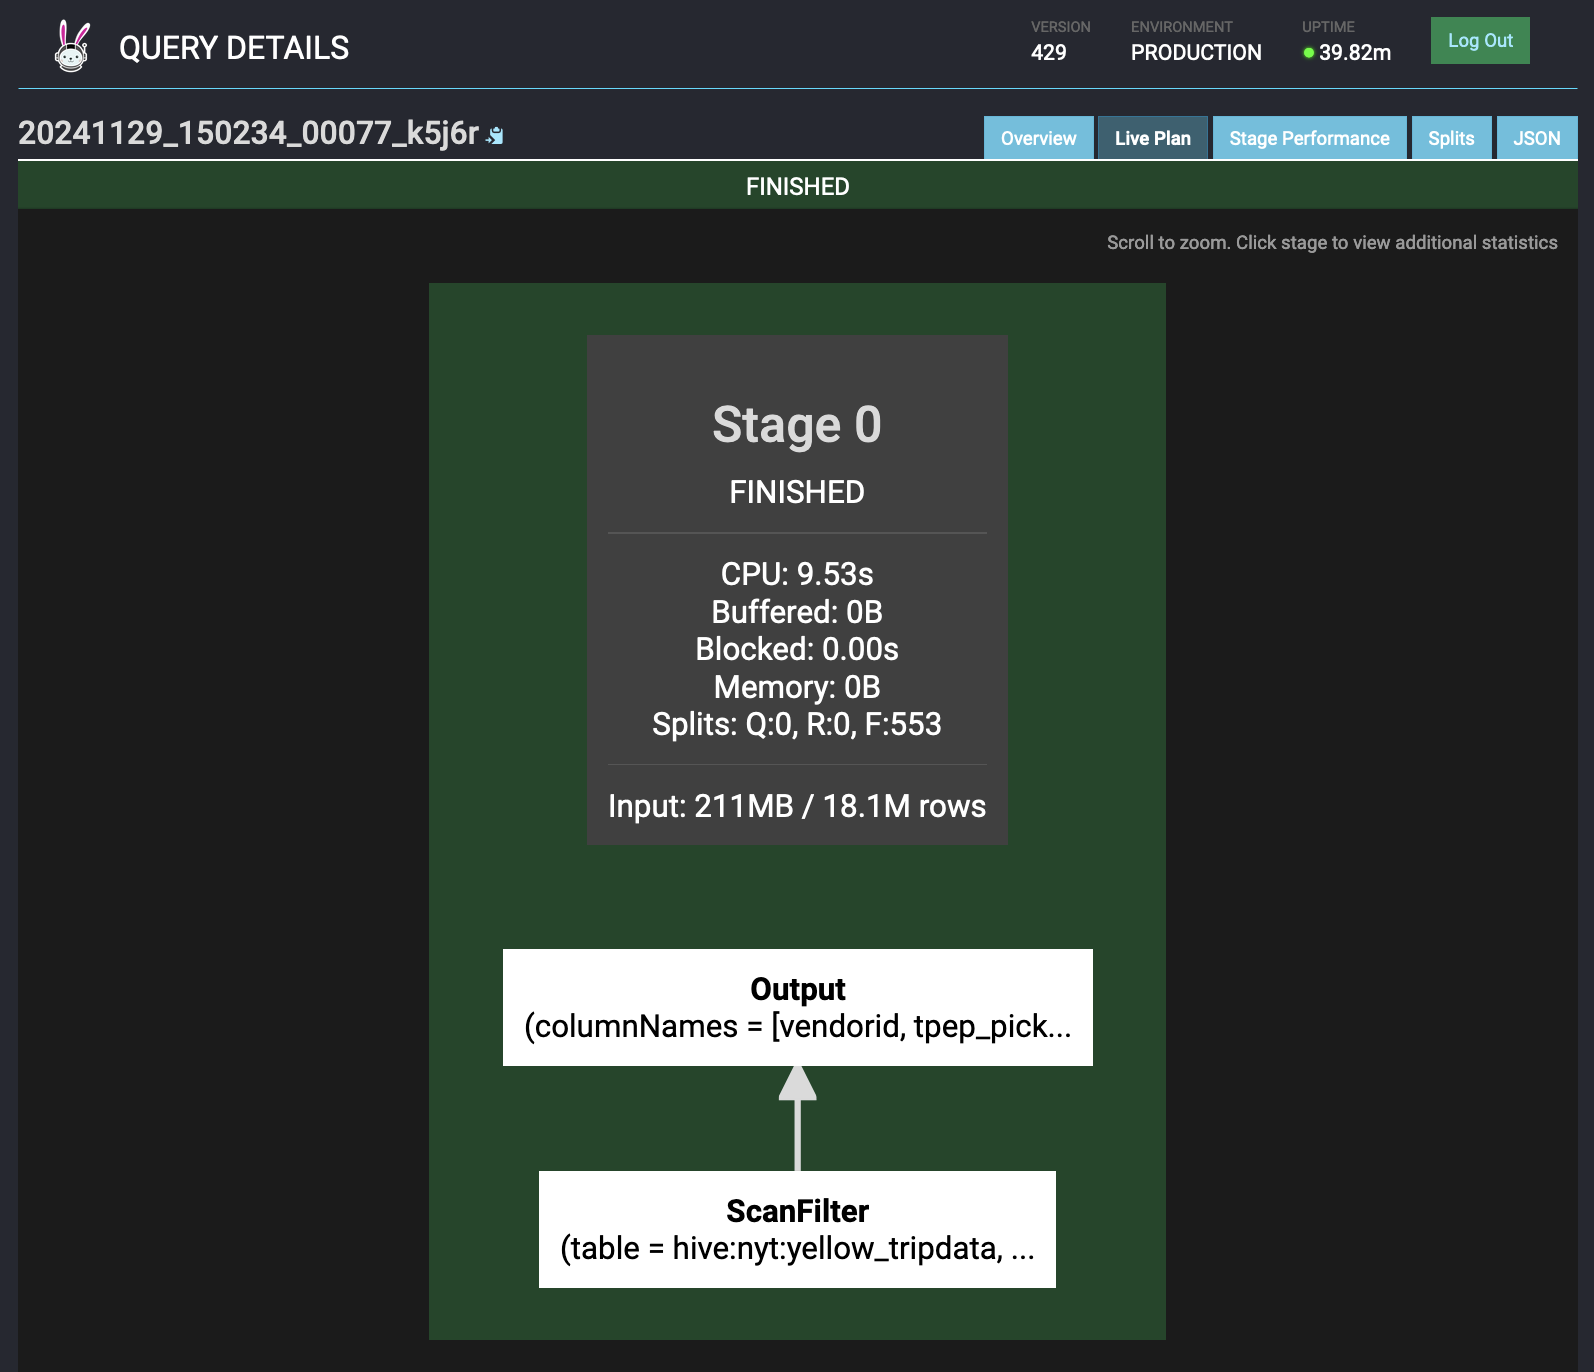
" />